# PyTorch cnn FMNIST with regularization 

We apply the following regularization techniques:
* L1 & L2 Regularization
* Data augmentation
* Drop out
* Early stopping
* Batch normalization

In [25]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

# check if cuda is usable
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

print(f"Using device: {device}")

Using device: cpu


In [13]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from lib.report import show_torch_image

## Build CNN for FMNIST without regularization

### Dataset loading and transform

In [34]:
normalizing_transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5, ), (0.5, )) ])

trainset = torchvision.datasets.FashionMNIST(root='./tmp/fmnist', 
                                             train=True,
                                             download=True, 
                                             transform=normalizing_transform)


testset = torchvision.datasets.FashionMNIST(root='./tmp/fmnist', 
                                            train=False,
                                            download=True, 
                                            transform=normalizing_transform)
print(f'train: {trainset.data.shape}')
print(f'test: {testset.data.shape}')


print(f'classes: {trainset.class_to_idx}')
class_names = list(trainset.class_to_idx.keys())
print(f'class_names: {class_names}')

train: torch.Size([60000, 28, 28])
test: torch.Size([10000, 28, 28])
classes: {'T-shirt/top': 0, 'Trouser': 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}
class_names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


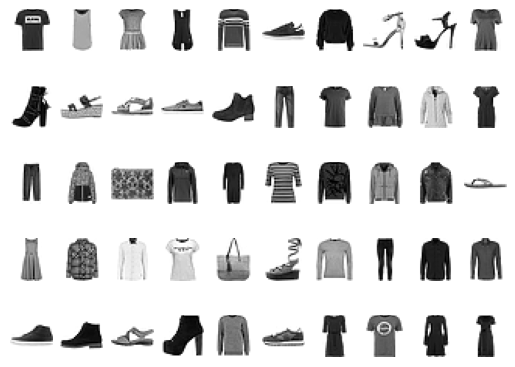

In [12]:
figure = plt.figure()
num_of_images = 50 

for index in range(1, num_of_images + 1):
    plt.subplot(5, 10, index)
    plt.axis('off')
    plt.imshow(trainset.data[index], cmap='gray_r')

In [20]:
# instantiate loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=16,
                                         shuffle=False, num_workers=2)

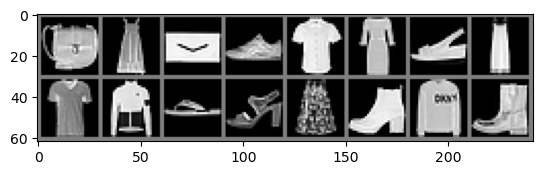

  Bag Dress   Bag Sneaker Shirt Dress Sandal Dress


In [21]:
# get random training images
train_iter = iter(trainloader)
images, labels = next(train_iter)

show_torch_image(torchvision.utils.make_grid(images))

print(' '.join('%5s' % class_names[labels[j]] for j in range(8)))

### Model definition

In [24]:
class NetNoReg(nn.Module):
    def __init__(self):
        super(NetNoReg, self).__init__()

        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_1 = nn.Linear(64 * 12 * 12, 128)
        self.fc_2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv_1(x))
        x = self.pool(F.relu(self.conv_2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


net = NetNoReg()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

NetNoReg(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=9216, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
)

### Training the model
We define the training loop as a function to be able to re-use it

In [39]:
def train(model, epochs, trainloader, testloader, criterion, optimizer, model_path = None):
    epoch_log = []
    loss_log = []
    accuracy_log = []

    for epoch in range(epochs):
        print(f'Epoch {epoch + 1} starting!')

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
        
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # clear the gradients
            optimizer.zero_grad()

            # forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
            # backpropagation and update of weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # run against test dataset
            if i % 50 == 49:
                correct = 0
                total = 0

                # no gradients needed for testing
                with torch.no_grad():
                    for images, labels in testloader:
                        images = images.to(device)
                        labels = labels.to(device)
                    
                        outputs = model(images)

                         # predictions from the maximum value of the predicted output tensor
                         # we set dim = 1 to reduce the dimensions
                        _, predicted = torch.max(outputs.data, dim = 1)
                        total += labels.size(0)
                        correct += (predicted == labels).sum().item()

                    accuracy = 100 * correct / total
                    epoch_num = epoch + 1
                    actual_loss = running_loss / 50
                    print(f'Epoch: {epoch_num}, Batches completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
                    running_loss = 0.0
    
        # update logs after each epoch
        epoch_log.append(epoch_num)
        loss_log.append(actual_loss)
        accuracy_log.append(accuracy)

    if model_path != None:
        torch.save(net.state_dict(), model_path)
        print(f"Saved to: '{model_path}'") 
    print('Training done!') 
    return epoch_log, loss_log, accuracy_log

### Train without regularization

In [ ]:
epoch_log, loss_log, accuracy_log = train(net, 5, trainloader, testloader, criterion, optimizer, model_path = './out/fmnist_cnn_no_reg.pth')

### Plot training results

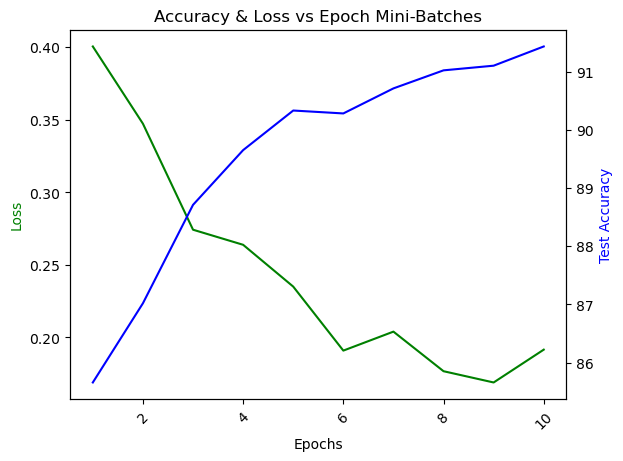

In [31]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()

## Build CNN for FMNIST with regularization

### Data augmentation
We can add more transformations to perform data augmentation

In [35]:
import PIL

augmentation_transform = transforms.Compose([
        transforms.RandomAffine(degrees = 25, translate = (0.1,0.1), shear = 10), 
        transforms.ColorJitter(hue = .1, saturation = .1),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25, interpolation = PIL.Image.BILINEAR),
        transforms.Grayscale(num_output_channels = 1),
        normalizing_transform
])

# we apply those new transforms only to the training set
trainset = torchvision.datasets.FashionMNIST(root='./tmp/fmnist', 
                                             train=True,
                                             download=True, 
                                             transform=augmentation_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)

### Add dropout and batch normalization
We add some dropout after the conv layers and a batch normalization layer between the conv layers.

In [36]:
class NetWithReg(nn.Module):
    def __init__(self):
        super(NetWithReg, self).__init__()

        self.conv_1 = nn.Conv2d(1, 32, 3)
        self.conv_1_norm = nn.BatchNorm2d(32)
        self.conv_2 = nn.Conv2d(32, 64, 3)
        self.conv_2_norm = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc_1 = nn.Linear(64 * 12 * 12, 128)
        self.fc_2 = nn.Linear(128, 10)
        self.drop_out = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv_1_norm(self.conv_1(x))
        x = F.relu(x)
        x = self.drop_out(x)
        x = self.conv_2_norm(self.conv_2(x))
        x = F.relu(x)
        x = self.drop_out(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc_1(x))
        x = self.fc_2(x)
        return x


net = NetWithReg()
net.to(device)

NetWithReg(
  (conv_1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_1_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_2_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=9216, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)

### L1 & L2 Regularization
Makes our network prefer to learn smaller weights by penalizing large weights in the loss function.  
L2 Regularization can be included in most optimizers by using the parameter `weight_decay.`

In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay = 0.001)

### Train with regularization

In [ ]:
epoch_log, loss_log, accuracy_log = train(net, 5, trainloader, testloader, criterion, optimizer, model_path = './out/fmnist_cnn_with_reg.pth')

Epoch 1 starting!
Epoch: 1, Batches completed: 50, Loss: 1.862, Test Accuracy = 56.530%
Epoch: 1, Batches completed: 100, Loss: 1.393, Test Accuracy = 55.500%
Epoch: 1, Batches completed: 150, Loss: 1.247, Test Accuracy = 64.290%
Epoch: 1, Batches completed: 200, Loss: 1.132, Test Accuracy = 69.080%
Epoch: 1, Batches completed: 250, Loss: 1.164, Test Accuracy = 66.320%
Epoch: 1, Batches completed: 300, Loss: 1.115, Test Accuracy = 70.660%
Epoch: 1, Batches completed: 350, Loss: 1.070, Test Accuracy = 68.590%
Epoch: 1, Batches completed: 400, Loss: 0.981, Test Accuracy = 68.850%
Epoch: 1, Batches completed: 450, Loss: 1.040, Test Accuracy = 69.330%
Epoch: 1, Batches completed: 500, Loss: 1.045, Test Accuracy = 70.640%
Epoch: 1, Batches completed: 550, Loss: 0.971, Test Accuracy = 71.420%
Epoch: 1, Batches completed: 600, Loss: 1.015, Test Accuracy = 72.710%
Epoch: 1, Batches completed: 650, Loss: 0.923, Test Accuracy = 71.140%
Epoch: 1, Batches completed: 700, Loss: 0.876, Test Accuracy

### Plot training results

In [ ]:
# To create a plot with secondary y-axis we need to create a subplot
fig, ax1 = plt.subplots()

# Set title and x-axis label rotation
plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

# We use twinx to create a plot a secondary y axis
ax2 = ax1.twinx()

# Create plot for loss_log and accuracy_log
ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

# Set labels
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()